#**RGB-> 0.4**

#**XYZ-> 0.6** 

In [1]:
!pip install -q tensorflow-io
import os
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras.layers import  Lambda, Input, Dense, \
                         Dropout
from keras.layers.merge import Concatenate
from tensorflow.keras.models import Model, Sequential 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow_hub as hub

from utils import DatasetBuilder ,EvaluateModel ,ModelUtils

     |████████████████████████████████| 25.9 MB 1.2 MB/s 


In [2]:
DATASET_PATH = os.path.join(os.getcwd(),'drive',"MyDrive", 'Car-Color-Recognition','CarDS')
BATCH_SIZE = 32
IMAGE_SIZE = (300 ,300)
colorspace = "RGB_XYZ_3"
model_name = "RGB_XYZ_3"
dsBuilder = DatasetBuilder(DATASET_PATH ,image_size = IMAGE_SIZE ,batch_size = BATCH_SIZE)
train_ds , val_ds = dsBuilder.create('train') , dsBuilder.create('val')
class_names=train_ds.class_names
NUM_CLASSES = len(class_names)

class_weights = dsBuilder.get_class_weights(train_ds)

for key ,value in class_weights.items() : print("{} : {}".format(class_names[key], value.round(3)))

Found 19171 files belonging to 16 classes.
Found 3491 files belonging to 16 classes.
beige : 1.161
black : 0.97
blue : 1.087
brown : 1.14
cream : 2.014
crimson : 1.945
gold : 2.147
green : 1.325
grey : 0.873
navy-blue : 2.031
orange : 1.39
red : 1.152
silver : 1.268
titanium : 1.997
white : 0.209
yellow : 1.297


In [3]:
rate = 0.4
def combine_rgb_xyz(rgb_image):
  xyz_image = DatasetBuilder.rgb2xyz(rgb_image)
  return (rgb_image*rate)+(xyz_image*(1-rate))

In [4]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    map(lambda img ,lbl : (combine_rgb_xyz(img) ,lbl) ,num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    map(lambda img ,lbl : (combine_rgb_xyz(img) ,lbl) ,num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

In [5]:
augmentation = Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.05),
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

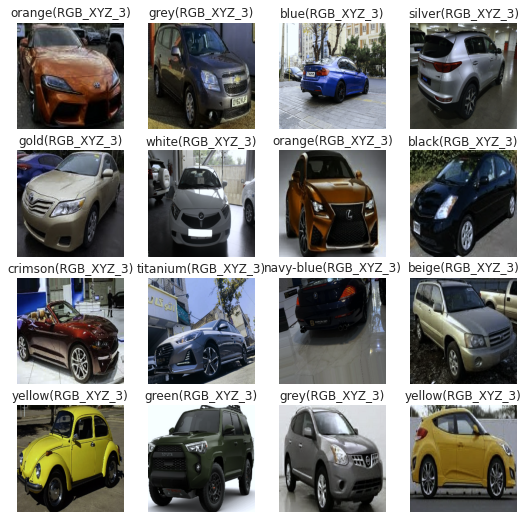

In [ ]:
fig=plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(16):
      plt.subplot(4, 4, i + 1)
      image = tf.expand_dims(images[i] ,axis=0)
      lbl = "{}({})".format(class_names[labels[i].numpy().argmax()] , colorspace )
      plt.imshow(tf.squeeze(image))
      plt.title(lbl)
      plt.axis("off")
    break

In [6]:
do_fine_tuning = True

url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2"
base_model = hub.KerasLayer(url,trainable=do_fine_tuning)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    augmentation,
    base_model,
    Dense(400),
    Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dense (Dense)               (None, 400)               614800    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                6416      
                                                                 
Total params: 13,551,838
Trainable params: 13,442,622
Non-trainable params: 109,216
_________________________________________________________________


In [ ]:
model_utils = ModelUtils(model_name ,"HUB")
run_index = 1
callbacks= model_utils.get_callbacks(run_index = run_index )
model = model_utils.make_or_restore_model(model,"SGD",lr = 1e-2)
n_epochs = 50
print("{}: ".format(model_name))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights
          )   

Creating a new model
RGB_XYZ_3: 
Epoch 1/50
600/600 [==============================] - ETA: 0s - loss: 0.9326 - accuracy: 0.7136
Epoch 1: val_loss improved from inf to 0.69488, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ_3/_1.h5
600/600 [==============================] - 3268s 5s/step - loss: 0.9326 - accuracy: 0.7136 - val_loss: 0.6949 - val_accuracy: 0.7923 - lr: 0.0100
Epoch 2/50
600/600 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.8400
Epoch 2: val_loss improved from 0.69488 to 0.59657, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ_3/_2.h5
600/600 [==============================] - 409s 678ms/step - loss: 0.5023 - accuracy: 0.8400 - val_loss: 0.5966 - val_accuracy: 0.8152 - lr: 0.0100
Epoch 3/50
600/600 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.8714
Epoch 3: val_loss did not improve from 0.59657
600/600 [==============================]

In [ ]:
model_utils.save_model_and_history(model ,run_index)

INFO:tensorflow:Assets written to: ram://aa9f0df6-ecd9-47c2-8db2-72c5fb10d7d6/assets


INFO:tensorflow:Assets written to: ram://aa9f0df6-ecd9-47c2-8db2-72c5fb10d7d6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Models/RGB_XYZ_3/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Models/RGB_XYZ_3/1/assets


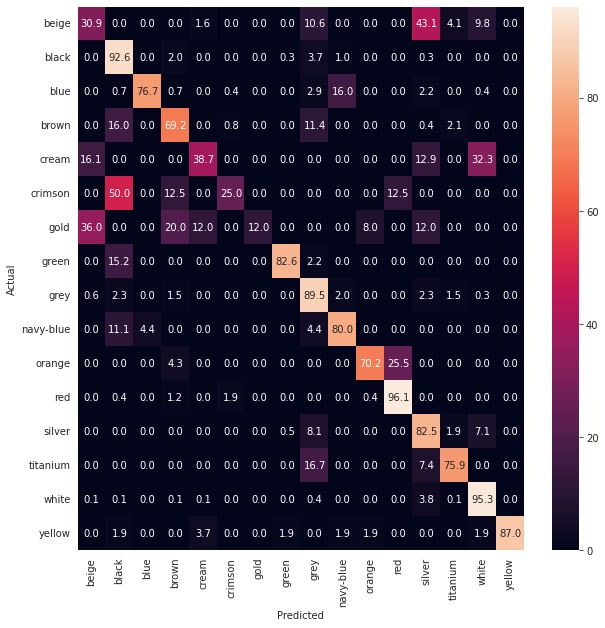

In [ ]:
eval = EvaluateModel(model ,val_ds ,class_names,"RGB_XYZ_3")
eval.plot_confusion()

In [7]:
run_index = 1

model_utils = ModelUtils(model_name ,"HUB")
model = model_utils.make_or_restore_model(model)
eval = EvaluateModel(model ,val_ds ,class_names,"RGB_XYZ_3")

Restoring from /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ_3/_6.h5


In [8]:
eval.report()

Report CSV file added to logs .


,precision,recall,f1-score,support
beige,0.678571,0.308943,0.424581,123.00000
black,0.802326,0.926174,0.859813,298.00000
blue,0.990610,0.767273,0.864754,275.00000
brown,0.863158,0.691983,0.768150,237.00000
cream,0.600000,0.387097,0.470588,31.00000
crimson,0.200000,0.250000,0.222222,8.00000
gold,1.000000,0.120000,0.214286,25.00000
green,0.926829,0.826087,0.873563,46.00000
grey,0.765586,0.895044,0.825269,343.00000
navy-blue,0.395604,0.800000,0.529412,45.00000


In [9]:
from tensorflow.keras.datasets.mnist import load_data

(_, _), (x_test, y_test) = load_data()

x_test_new = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

11501568/11490434 [==============================] - 0s 0us/step


In [10]:
x_test.shape

(10000, 28, 28)

In [11]:
x_test_new.shape

(10000, 28, 28, 1)

In [12]:
x_test.shape+(3,)

(10000, 28, 28, 3)

In [2]:
!pip install nsvision
import nsvision as nv

image = nv.imread('/content/crimson.jpeg', resize = (300,300), color_mode='rgb',normalize=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.6 MB/s 
     |████████████████████████████████| 20.2 MB 1.2 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.18.3 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires numpy>=1.20, but you have numpy 1.18.3 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.3 which is incompatible.
kapre 0.3.7 requir

In [6]:
instances = list()

In [4]:
image.shape

(300, 300, 3)

In [7]:
instances.append(image)
instances.append(image)
instances.append(image)

In [9]:
import numpy as np
z = np.array(instances)

In [10]:
z.shape

(3, 300, 300, 3)

In [11]:
z[:2].shape

(2, 300, 300, 3)

In [ ]:
z.tolist()